In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
class CFG:
    sequence_length = 1024
    vocab_size = 10000

# Loading dataset


In [4]:
negative_df = pd.read_csv("true.csv")
negative_df["fake"] = 0.0
positive_df = pd.read_csv("fake.csv")
positive_df["fake"] = 1.0
train_df = pd.concat([negative_df, positive_df])
train_df.head()

,title,text,subject,date,fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0.0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0.0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0.0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0.0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0.0


# Exploring the Data 

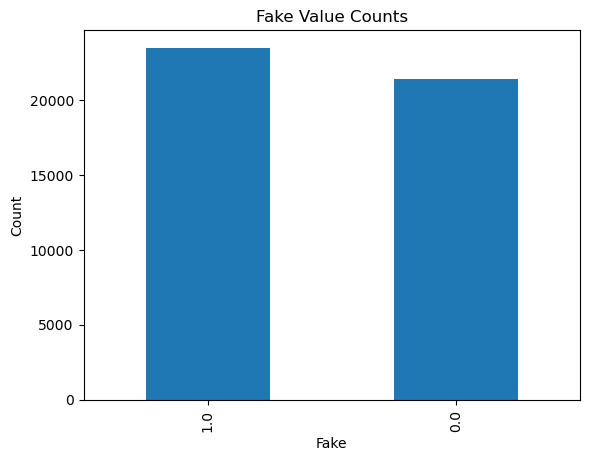

In [5]:
train_df['fake'].value_counts().plot(kind="bar")
plt.title('Fake Value Counts')
plt.xlabel('Fake')
plt.ylabel('Count')
plt.show()

In [6]:
train_df["title_length"] = train_df["title"].apply(lambda title: len(title.split(" ")))
train_df["text_length"] = train_df["text"].apply(lambda text: len(text.split(" ")))

In [7]:
train_df[["title_length", "text_length"]].describe()

,title_length,text_length
count,44898.000000,44898.000000
mean,12.657245,415.760412
std,4.170713,361.648003
min,1.000000,1.000000
25%,10.000000,208.000000
50%,12.000000,371.000000
75%,15.000000,525.000000
max,45.000000,8436.000000


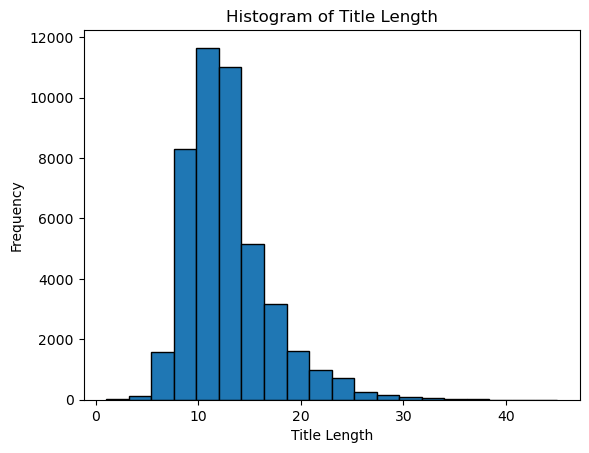

In [8]:
train_df["title_length"].plot(kind="hist", bins=20, edgecolor='black')
plt.title('Histogram of Title Length')
plt.xlabel('Title Length')
plt.ylabel('Frequency')
plt.show()

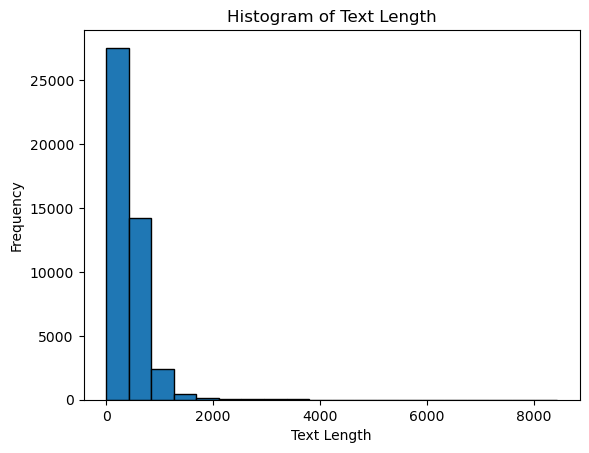

In [9]:
train_df["text_length"].plot(kind="hist", bins=20, edgecolor='black')
plt.title('Histogram of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Create tensorflow dataset

In [10]:
train_data, valid_data = train_test_split(train_df, test_size=0.2, stratify=train_df["fake"], random_state=42)
train_data.shape, valid_data.shape

((35918, 7), (8980, 7))

In [11]:
def create_dataset(dataframe, shuffle=True):
    # Create a TensorFlow dataset from the text and fake columns of the dataframe
    dataset = tf.data.Dataset.from_tensor_slices((dataframe["text"], dataframe["fake"]))
    if shuffle:
         # Shuffle the dataset if the shuffle parameter is True
        dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    # Batch the dataset into smaller batches of size 256
    dataset = dataset.batch(256).cache().prefetch(tf.data.AUTOTUNE)
    # Prefetch the next batch of data to further optimize training
    return dataset

In [12]:
train_ds = create_dataset(train_data)
valid_ds = create_dataset(valid_data, shuffle=False)

# Training the LSTM Mode

In [13]:
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=CFG.vocab_size, 
    output_sequence_length=CFG.sequence_length, 
    pad_to_max_tokens=True
)
# Adapt the TextVectorization layer to the training data
vectorizer.adapt(train_df["text"], batch_size=1024)

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    vectorizer,
    tf.keras.layers.Embedding(
        input_dim=CFG.vocab_size, 
        output_dim=64,
        input_length=CFG.sequence_length, 
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), 
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), 
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
    metrics=[
        "accuracy", 
        tf.keras.metrics.AUC(name="auc")
    ]
)
model.summary()
tf.keras.utils.plot_model(model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 1024)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 1024, 64)          640000    
                                                                 
 bidirectional (Bidirection  (None, 1024, 128)         66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                        

In [16]:
file_path = "model.tf"
history = model.fit(
    train_ds, 
    epochs=3, 
    validation_data=valid_ds,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            file_path,
            save_best_only=True,
            monitor='val_accuracy',
            mode='max'
        )
    ]
)

Epoch 1/3
141/141 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000 - auc: 1.0000INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets


141/141 [==============================] - 498s 4s/step - loss: 0.0014 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.0049 - val_accuracy: 0.9993 - val_auc: 0.9997
Epoch 2/3
141/141 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000 - auc: 1.0000INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets


141/141 [==============================] - 494s 4s/step - loss: 0.0010 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.0047 - val_accuracy: 0.9994 - val_auc: 0.9997
Epoch 3/3
141/141 [==============================] - 488s 3s/step - loss: 7.7880e-04 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.0047 - val_accuracy: 0.9994 - val_auc: 0.9997


# Plot learning curve 

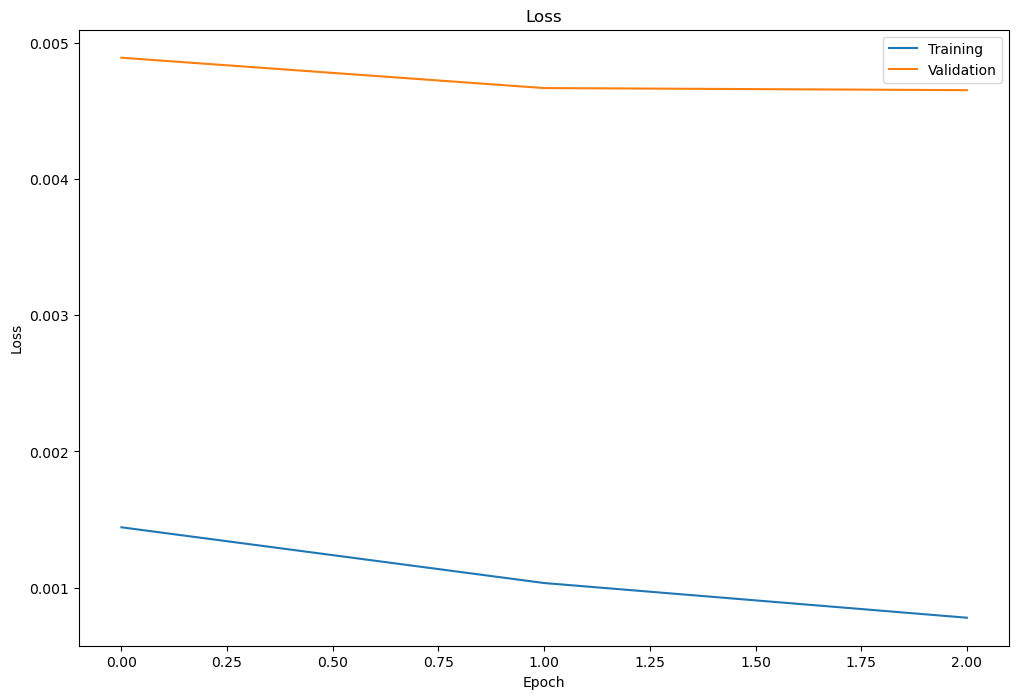

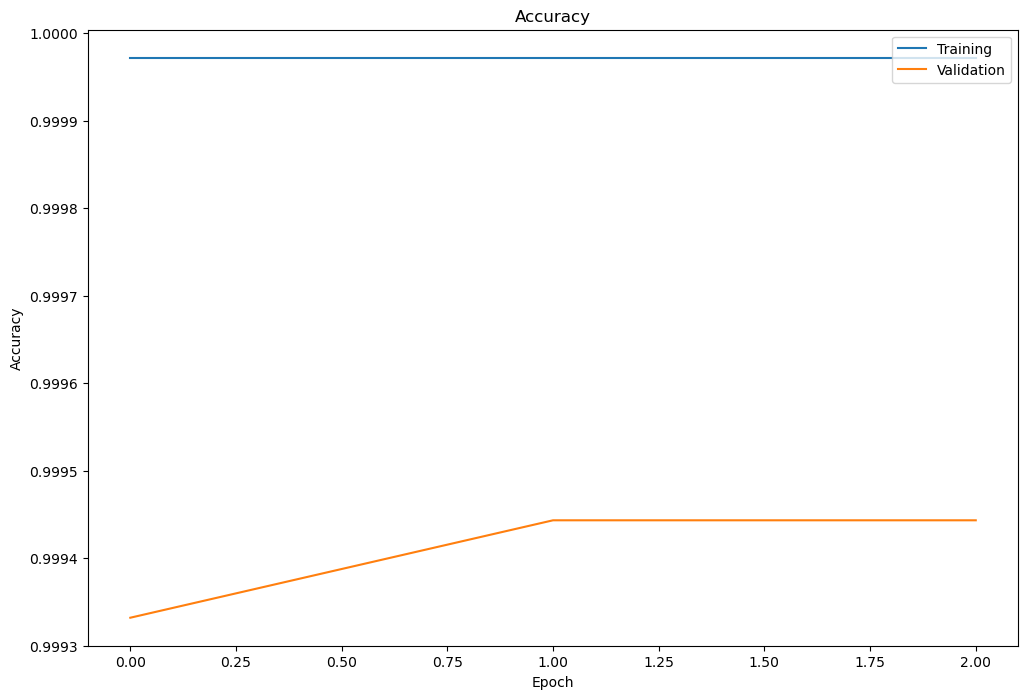

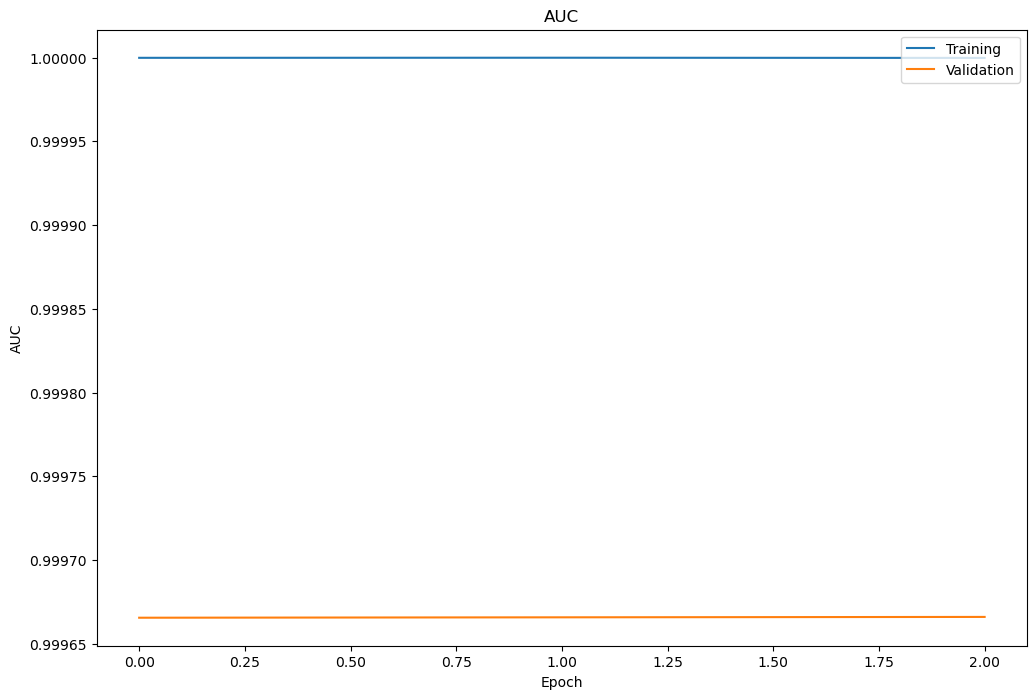

In [17]:
def plot_learning_curve(history):
  plt.figure(figsize=(12, 8))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper right')

  plt.figure(figsize=(12, 8))
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper right')

  plt.figure(figsize=(12, 8))
  plt.plot(history.history['auc'])
  plt.plot(history.history['val_auc'])
  plt.title('AUC')
  plt.ylabel('AUC')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper right')
  plt.show()
plot_learning_curve(history)

In this notebook, we have demonstrated the application of a LSTM neural network for detecting fake news. The process involved loading the data, exploring its features, and subsequently training and evaluating the LSTM model.

The LSTM model showcased impressive performance, achieving an accuracy ranging from 99.8% to 99.9% on the validation set. This indicates the model's capability to accurately classify 998 to 999 out of 1000 articles as either real or fake news. Such high accuracy underscores the potential effectiveness of LSTMs in fake news detection.

Nevertheless, it is crucial to acknowledge that the LSTM model is not infallible. There exists the possibility of errors, and certain articles may elude correct classification. Therefore, employing the LSTM model in conjunction with other detection methods, such as human common sense and fact-checking, is advisable.

In summary, the LSTM model stands as a potent tool for fake news detection, offering ease of use and high accuracy. However, it should be utilized judiciously, recognizing its imperfections and complementing it with additional strategies for a comprehensive approach to fake news identification.